In [2]:
import calendar
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
from tabulate import tabulate

## Isolate RNX SV

In [4]:
def process_rnx(satellite_name,yr,dd):

    input_filename = f"gps_rnx_{yr}{dd}.npz"

    if not os.path.exists(input_filename):
        raise FileNotFoundError(f"The file {input_filename} does not exist.")
    
    data = np.load(input_filename)
    
    satellite_names = data['satellite']
    year = data['yyyy']
    month = data['mm']
    day = data['dd']
    hour = data['hh']
    minutes = data['mi']
    second = data['ss']
    coeff_clock_bias = data['coeff_clock_bias']
    coeff_block_bias_drift = data['coeff_clock_bias_drift']
    coeff_clock_bias_drift_rate = data['coeff_clock_bias_drift_rate']
    dn = data['delta_mean_motion']
    m0 = data['ref_mean_anomaly']
    ecc = data['eccentricity']
    sqA = data['semi_major_ax']
    toe = data['t_oe']
    health = data['sv_health']
    files = data['files']
    
    matching_indices = [i for i, name in enumerate(satellite_names) if name.startswith(satellite_name)]

    matching_satellite_names = satellite_names[matching_indices]
    matching_year= year[matching_indices]
    matching_month= month[matching_indices]
    matching_day= day[matching_indices]
    matching_hour= hour[matching_indices]
    matching_minutes= minutes[matching_indices]
    matching_second= second[matching_indices]
    matching_coeff_clock_bias= coeff_clock_bias[matching_indices]
    matching_coeff_clock_bias_drift= coeff_block_bias_drift[matching_indices]
    matching_coeff_clock_bias_drift_rate= coeff_clock_bias_drift_rate[matching_indices]
    matching_dn = dn[matching_indices]
    matching_m0 = m0[matching_indices]
    matching_ecc = ecc[matching_indices]
    matching_sqA = sqA[matching_indices]
    matching_toe = toe[matching_indices]
    matching_health = health[matching_indices]
    matching_files= files[matching_indices]
        
    output_filename = f"gps_rnx_{yr}{dd}_{satellite_name}.npz"
    
    np.savez(output_filename, 
             satellite = matching_satellite_names, 
             yyyy = matching_year, 
             mm = matching_month, 
             dd = matching_day, 
             hh = matching_hour, 
             mi = matching_minutes, 
             ss = matching_second, 
             clock_bias_coefficients = matching_coeff_clock_bias, 
             clock_bias_drift_coefficients = matching_coeff_clock_bias_drift, 
             clock_bias_drift_rate_coefficients = matching_coeff_clock_bias_drift_rate,
             diff_mean_motion = matching_dn,
             ref_mean_anomaly = matching_m0,
             eccen = matching_ecc,
             sqrt_semi = matching_sqA,
             t_eph = matching_toe,
             health_sv = matching_health,
             filename = matching_files)
    
    print(f"Data has been saved to {output_filename}")

In [5]:
process_rnx('G21','2019','008')

Data has been saved to gps_rnx_2019008_G21.npz


In [6]:
data_g21 = np.load('gps_rnx_2019008_G21.npz')
data_g21.files

['satellite',
 'yyyy',
 'mm',
 'dd',
 'hh',
 'mi',
 'ss',
 'clock_bias_coefficients',
 'clock_bias_drift_coefficients',
 'clock_bias_drift_rate_coefficients',
 'diff_mean_motion',
 'ref_mean_anomaly',
 'eccen',
 'sqrt_semi',
 't_eph',
 'health_sv',
 'filename']

In [7]:
np.set_printoptions(threshold=np.inf)  # Prevent truncation of array output
# print(data_g21['t_eph'])

## Plot Polynomial

In [9]:
# Load the data
broadcast = np.load('gps_rnx_2019008_G21.npz')

# Extract the arrays
satellite = broadcast['satellite']
yyyy = broadcast['yyyy']
mm = broadcast['mm']
dd = broadcast['dd']
hh = broadcast['hh']
mi = broadcast['mi']
ss = broadcast['ss']
coeff_clock_bias = broadcast['clock_bias_coefficients']
coeff_clock_bias_drift = broadcast['clock_bias_drift_coefficients']
coeff_clock_bias_drift_rate = broadcast['clock_bias_drift_rate_coefficients']
mean_motion_diff = broadcast['diff_mean_motion'] 
mean_anomaly_0 = broadcast['ref_mean_anomaly'] 
ecc = broadcast['eccen'] 
sqrt_semi_major = broadcast['sqrt_semi'] 
t_oe = broadcast['t_eph']
health = broadcast['health_sv']
 
# Combine date and time into datetime objects
epochs = [datetime(year, month, day, hour, minute, second)
          for year, month, day, hour, minute, second 
          in zip(yyyy, mm, dd, hh, mi, ss)]

# Calculate time differences in seconds
time_differences = [(epochs[i+1] - epochs[i]).total_seconds() for i in range(len(epochs)-1)]

In [10]:
# calculate the start of the week (Sunday at 12:00 AM UTC)
def start_of_week(t):
    
    # Find the weekday (0 = Monday, 6 = Sunday)
    weekday = t.weekday()
    
    # Calculate the start of the week
    start_of_week_dt = t - timedelta(days=(weekday + 1) % 7, hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
    
    return start_of_week_dt

In [11]:
(epochs[27]+timedelta(seconds=18)-start_of_week(epochs[27])).total_seconds()

172818.0

In [12]:
# Initialize list to store polynomial values and corresponding datetime strings
poly_values = []
time_strings = []

In [13]:
mu = 3.986005e14 # earth's gravitational constant [m^3/s^2]
c = 2.99792458e8
F = -2*np.sqrt(mu)/c**2
leap_sec = 18

In [14]:
# Calculate polynomial values
for i in range(len(epochs)-1):
    if health[i] == 0: 
            dt = 0
            while dt <= time_differences[i]: ## iffy 
                t_gps = epochs[i] + timedelta(seconds=dt)
                start_of_week_t = start_of_week(t_gps)
                t = (t_gps - start_of_week_t).total_seconds() + leap_sec
                t_k = t - t_oe[i]

                if t_k > 302400:
                    t_k -= 604800
                elif t_k < -302400:
                    t_k += 604800
                
                A = sqrt_semi_major[i]**2

                n_0 = np.sqrt(mu/(A**3))

                n = n_0 + mean_motion_diff[i]

                M_k = mean_anomaly_0[i] + (n*t_k)


                # Eccentric anomaly 
                
                E_0 = M_k 
                E_1 = E_0 + ((M_k - E_0 + ecc[i] * np.sin(E_0)) / (1 - ecc[i] * np.cos(E_0))) 
                E_2 = E_1 + ((M_k - E_1 + ecc[i] * np.sin(E_1)) / (1 - ecc[i] * np.cos(E_1))) 
                E_3 = E_2 + ((M_k - E_2 + ecc[i] * np.sin(E_2)) / (1 - ecc[i] * np.cos(E_2))) 
                E_4 = E_3 + ((M_k - E_3 + ecc[i] * np.sin(E_3)) / (1 - ecc[i] * np.cos(E_3))) 

                E_k = E_4

                dT_r = F*ecc[i]*sqrt_semi_major[i]*np.sin(E_k)
                
                poly_value = (coeff_clock_bias[i] + 
                              coeff_clock_bias_drift[i] * dt + 
                              coeff_clock_bias_drift_rate[i] * dt**2 + 
                              dT_r)

                poly_values.append(poly_value)
                time_strings.append((epochs[i] + timedelta(seconds=dt)).strftime('%Y:%m:%d:%H:%M:%S'))
                dt += 3600 # hourly increments

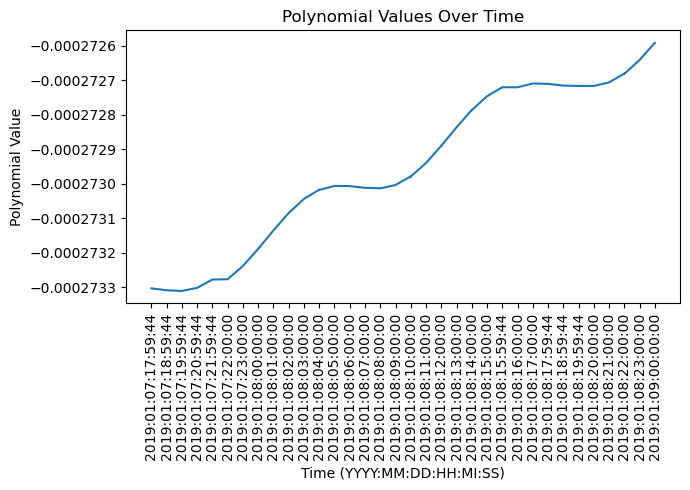

CPU times: user 284 ms, sys: 9.9 ms, total: 294 ms
Wall time: 121 ms


In [15]:
%%time
# Plot the results
plt.figure(figsize=(7, 5))
plt.plot(time_strings, poly_values)
plt.xlabel('Time (YYYY:MM:DD:HH:MI:SS)')
plt.ylabel('Polynomial Value')
plt.title('Polynomial Values Over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

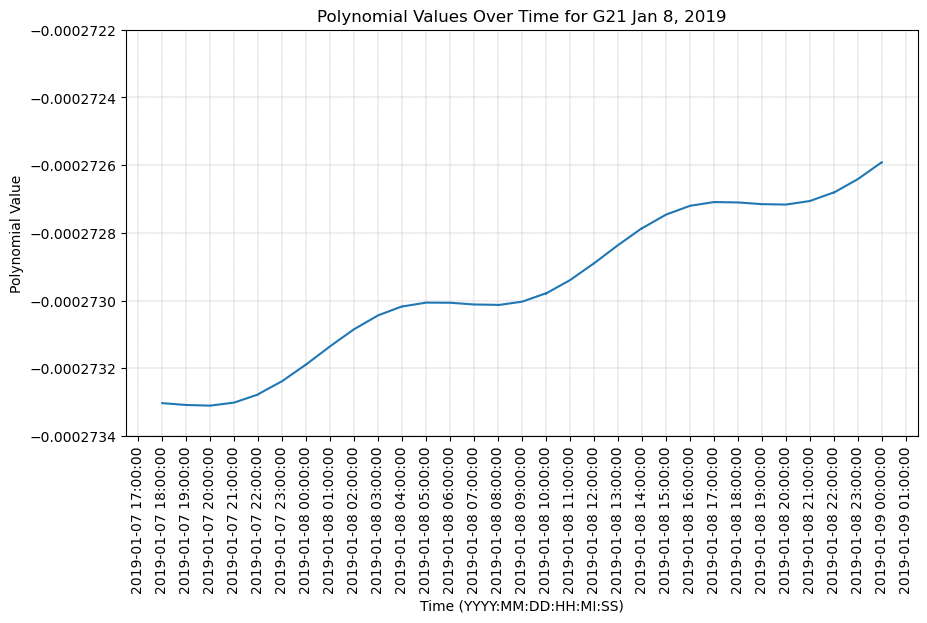

In [16]:
# Convert time strings to datetime objects
time_datetimes = [datetime.strptime(ts, '%Y:%m:%d:%H:%M:%S') for ts in time_strings]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(time_datetimes, poly_values)
plt.xlabel('Time (YYYY:MM:DD:HH:MI:SS)')
plt.ylabel('Polynomial Value')
plt.ylim(-0.0002734,-0.0002722)

plt.title('Polynomial Values Over Time for G21 Jan 8, 2019')

# Format the x-axis to show dates correctly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set major ticks every hour

plt.tight_layout()
plt.grid(color='gray', linestyle='--', linewidth=0.25)
plt.xticks(rotation=90)
plt.show()